## This notebook explores the effect of changing the parameters for jerk identification. 

In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [2]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [3]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [4]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [5]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

# Analysis of jerk 9.

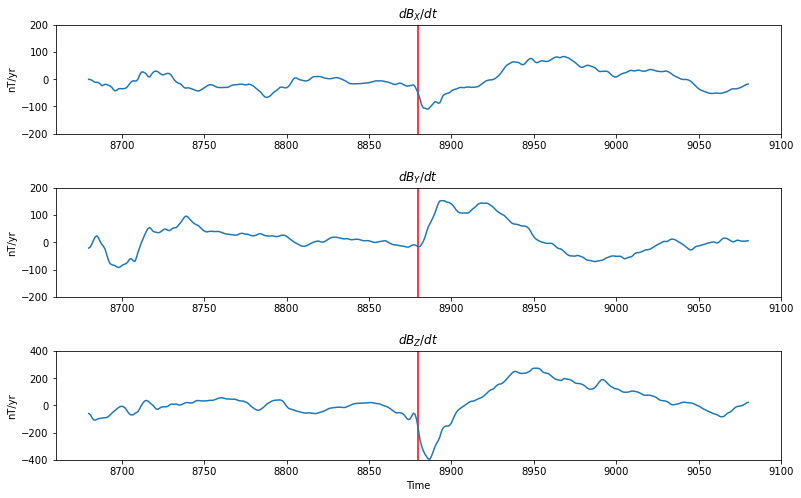

In [6]:
# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
import chaosmagpy as cp

radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_SV_timeseries.pdf')

#### Now check the influence of the error budget

#### Run jerk finder on using a 5%, 10%, 15% relative error on 400 year interval (400 data).

In [9]:
jerk_number = 8 # in Python indexing (i.e. event 9)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV

SV_errors = np.array([5,10,15,20])
num_SV_errors = SV_errors.shape[0]

discretise_size = 100
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=int )
Acceptance_rates_save = np.zeros( (num_SV_errors,len(run_components),4),dtype=float)
av_hist_save =  np.zeros( (num_SV_errors,len(run_components),discretise_size), dtype=float )

for error_j_index, error_j in enumerate(SV_errors):
    
    for run_component_index,i in enumerate(run_components):
        if i == 0:
            SV = Bx_dot
        elif i == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        delta_SV = error_j * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
        SV_MIN = -400
        SV_MAX = 400

        K_MIN = 0
        K_MAX = 100
        sigmas = np.array([20,10,20],dtype = float)
        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
        # sigma_change_value = sigmas(1)
        # sigma_move = sigmas(2)
        # sigma_birth = sigmas(3)

        THIN = 100
        NBINS = 100
        credible = 0.0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 2000000+burn_in
        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
     median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
     MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        CP_hist_save[error_j_index,run_component_index,:] = CP[:]
        delta_hist_save[error_j_index,run_component_index,:] = delta_slope[:]
        Acceptance_rates_save[error_j_index,run_component_index,:] = Acceptance_rates[:]
        av_hist_save[error_j_index,run_component_index,:] = AV[:]

    

In [109]:
# Acceptance rates for SV errors, averaged over the vector components.

# The sigma parameters seem to generate acceptable acceptance ratios.
print(np.sum(Acceptance_rates_save[:,:,:]/Acceptance_rates_save.shape[1],axis=1))


[[28.27283287 16.45110003  3.93178105  3.94220352]
 [42.02626673 28.04337056  5.85369444  5.86995681]
 [49.56986872 34.85435677  6.93889523  6.95797205]
 [54.32329941 40.43412145  7.59780264  7.61879953]]


#### Plot the average models:

<Figure size 432x288 with 0 Axes>

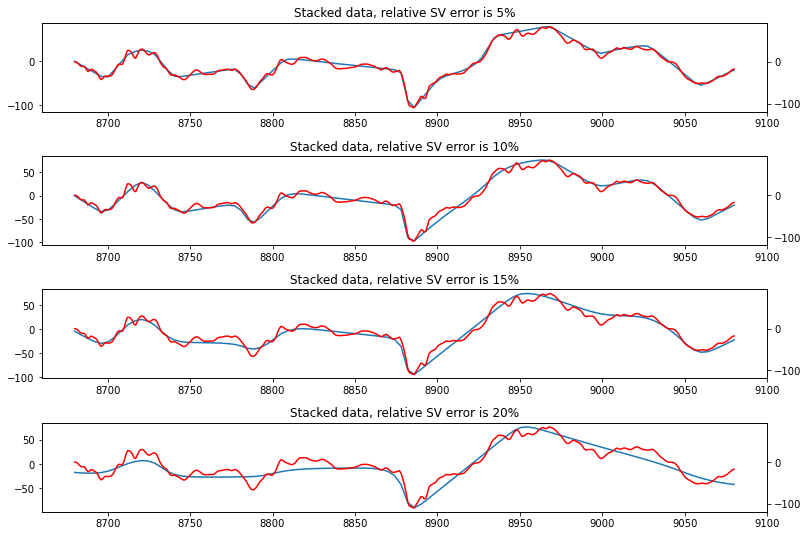

In [27]:
plt.figure()
time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)

f, ax = plt.subplots(av_hist_save.shape[0], 1, figsize=(13,9) )

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(ax.shape[0]):
    ax[i].set_title(r'Average model, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].plot(time_for_plotting, av_hist_save[i,0,:])
    axb = ax[i].twinx()
    axb.plot(time_yearly, Bx_dot,'r' )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




#### Conclusion: models agree quite well. It doesn't appear to matter a great deal what the SV error is.

#### Stacked data: average absolute gradient

Jerk time from stacked average of gradient is 8885.500000
Jerk time from stacked average of gradient is 8882.500000
Jerk time from stacked average of gradient is 8879.500000
Jerk time from stacked average of gradient is 8879.500000


<Figure size 432x288 with 0 Axes>

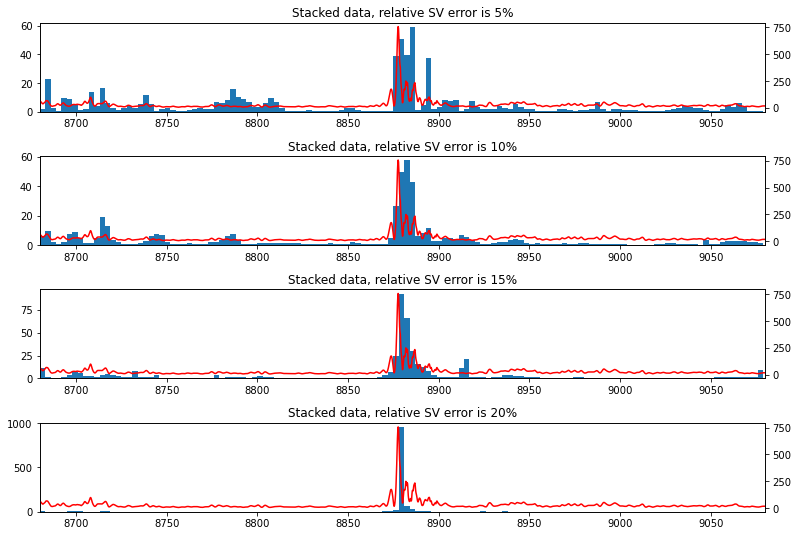

In [28]:
plt.figure()

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
fac = (NSAMPLE-burn_in)/THIN

for i in range(ax.shape[0]):
    ax[i].set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].bar(left_edges, np.sum(delta_hist_save[i,:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
    axb = ax[i].twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax[i].set_xlim(time_yearly.min(), time_yearly.max() )

    time_index_delta = np.argmax(np.sum(delta_hist_save[i,:,:],axis=0))
    print('Jerk time from stacked average of gradient is {0:f}'.
      format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)





#### Stacked data: absolute gradient of the average 

In [12]:
# Define a function to calculate the change in slope. Uses one-sided differences excluding the query point.
# This avoids the case where an apex of the function modelled, is in between two grid points x_i, and x_{i+1}. 
# Here, the left one-sided gradient at x_i, and the right one-sided gradient at x_{i+1} will be accurate, 
# but using x_i and x_{i+1} to calculate the gradient will give a large error.

def calc_delta_slope(timeseries, delta_t):
    delta_slope = np.zeros( len(timeseries) )
    
    for i in range(len(timeseries)):
        if i > 2 and i < len(timeseries)-2 :
            delta_slope[i] = abs(timeseries[i+2] -  timeseries[i+1] - timeseries[i-1] + timeseries[i-2] )/delta_t
    return delta_slope

    

Jerk time from gradient of average is 8886.060606 with SV error of 5%
Jerk time from gradient of average is 8886.060606 with SV error of 10%
Jerk time from gradient of average is 8886.060606 with SV error of 15%
Jerk time from gradient of average is 8886.060606 with SV error of 20%


<Figure size 432x288 with 0 Axes>

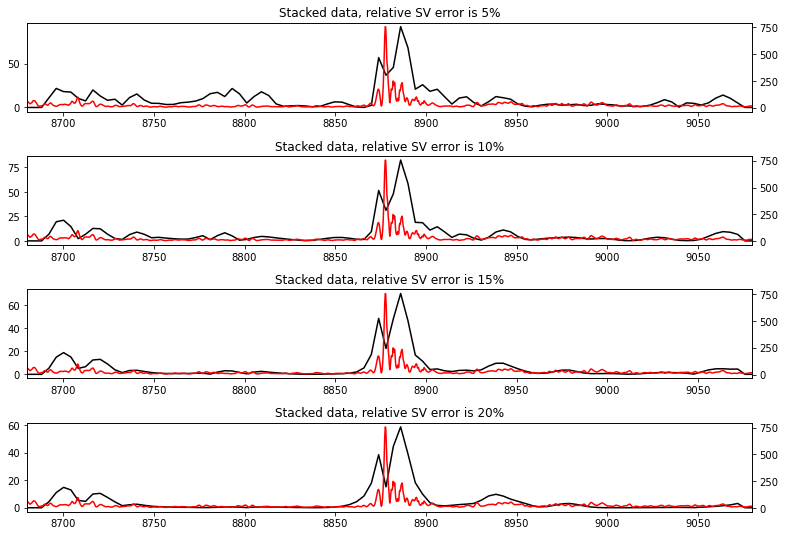

In [24]:
plt.figure()

time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)
delta_t = time_for_plotting[1] - time_for_plotting[0]

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(ax.shape[0]):
    ax[i].set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].plot( time_for_plotting, 
               calc_delta_slope(av_hist_save[i,0,:],delta_t) + 
               calc_delta_slope(av_hist_save[i,1,:],delta_t) +
               calc_delta_slope(av_hist_save[i,2,:],delta_t),'k')
    axb = ax[i].twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax[i].set_xlim(time_yearly.min(), time_yearly.max() )
    
    print(r'Jerk time from gradient of average is {0:f} with SV error of {1:d}%'.format(
    time_for_plotting[(
        calc_delta_slope(av_hist_save[i,0,:],delta_t) + 
        calc_delta_slope(av_hist_save[i,1,:],delta_t) +
        calc_delta_slope(av_hist_save[i,2,:],delta_t)    ).argmax()],SV_errors[i]) )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




## Convergence as a function of chain length

In [33]:
jerk_number = 8 # in Python indexing (i.e. event 9)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV

SV_errors = np.array([5])
num_SV_errors = SV_errors.shape[0]

discretise_size = 100
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=int )
Acceptance_rates_save = np.zeros( (num_SV_errors,len(run_components),4),dtype=float)
median_delta_hist_save =  np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )

for error_j_index, error_j in enumerate(SV_errors):
    
    for run_component_index,i in enumerate(run_components):
        if i == 0:
            SV = Bx_dot
        elif i == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        delta_SV = error_j * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
        SV_MIN = -400
        SV_MAX = 400

        K_MIN = 0
        K_MAX = 100
        sigmas = np.array([20,10,20],dtype = float)
        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
        # sigma_change_value = sigmas(1)
        # sigma_move = sigmas(2)
        # sigma_birth = sigmas(3)

        THIN = 100
        NBINS = 100
        credible = 0.0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 200000+burn_in
        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
     median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
     MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        CP_hist_save[error_j_index,run_component_index,:] = CP[:]
        delta_hist_save[error_j_index,run_component_index,:] = delta_slope[:]
        Acceptance_rates_save[error_j_index,run_component_index,:] = Acceptance_rates[:]
        median_delta_hist_save[error_j_index,run_component_index,:] = median_delta_slope[:]

    

<Figure size 432x288 with 0 Axes>

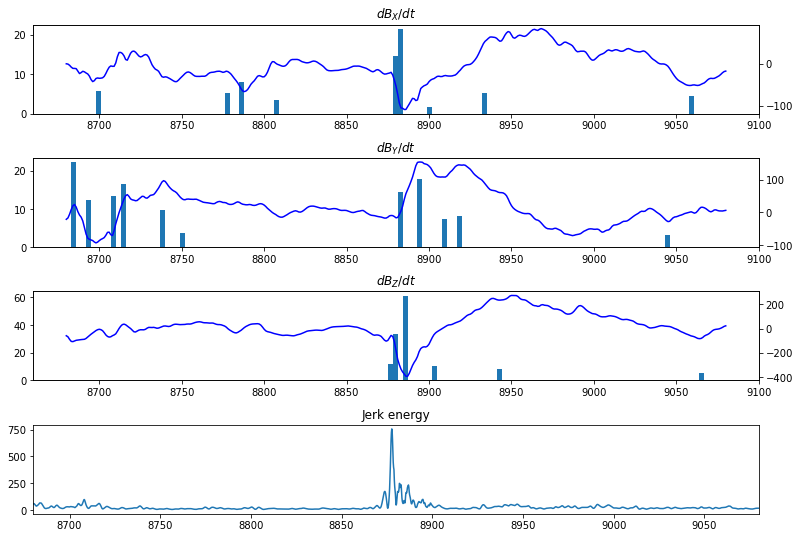

In [34]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, median_delta_hist_save[0,0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, median_delta_hist_save[0,1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, median_delta_hist_save[0,2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))



ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


In [35]:
median_delta_hist_save[0,2,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       11.646491  , 33.40718106,  0.        , 61.16412771,  0.  

## Investigate the effect of the length of the given timeseries. Here, I double the timeseries to 800 years from 400 years. 

In [29]:
jerk_number = 8 # in Python indexing (i.e. event 9)

time_yearly = np.arange(jerk_times[jerk_number]-400,jerk_times[jerk_number]+400+1)


Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV

SV_errors = np.array([5,10,15,20])
num_SV_errors = SV_errors.shape[0]

discretise_size = 100

TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=int )
Acceptance_rates_save = np.zeros( (num_SV_errors,len(run_components),4),dtype=float)
av_hist_save =  np.zeros( (num_SV_errors,len(run_components),discretise_size), dtype=float )

for error_j_index, error_j in enumerate(SV_errors):
    
    for run_component_index,i in enumerate(run_components):
        if i == 0:
            SV = Bx_dot
        elif i == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        delta_SV = error_j * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
        SV_MIN = -400
        SV_MAX = 400

        K_MIN = 0
        K_MAX = 100
        sigmas = np.array([20,10,20],dtype = float)
        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
        # sigma_change_value = sigmas(1)
        # sigma_move = sigmas(2)
        # sigma_birth = sigmas(3)

        THIN = 100
        NBINS = 100
        credible = 0.0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 2000000+burn_in
        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        CP_hist_save[error_j_index,run_component_index,:] = CP[:]
        delta_hist_save[error_j_index,run_component_index,:] = delta_slope[:]
        Acceptance_rates_save[error_j_index,run_component_index,:] = Acceptance_rates[:]
        av_hist_save[error_j_index,run_component_index,:] = AV[:]

    

#### Plot the average models:

AttributeError: 'AxesSubplot' object has no attribute 'shape'

<Figure size 432x288 with 0 Axes>

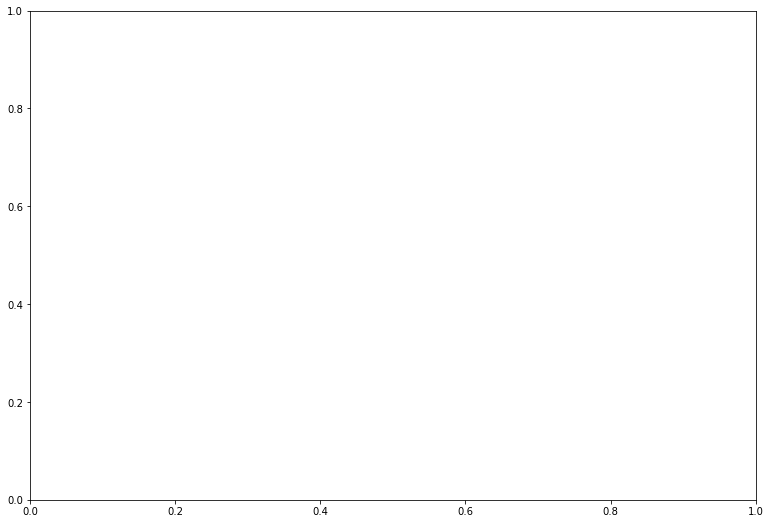

In [35]:
plt.figure()
time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)

f, ax = plt.subplots(av_hist_save.shape[0], 1, figsize=(13,9) )

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(ax.shape[0]):
    ax[i].set_title(r'Average model, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].plot(time_for_plotting, av_hist_save[i,0,:])
    axb = ax[i].twinx()
    axb.plot(time_yearly, Bx_dot,'r' )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




#### Stacked data: average absolute gradient

Jerk time from stacked average of gradient is 9261.500000
Jerk time from stacked average of gradient is 9171.500000
Jerk time from stacked average of gradient is 9075.500000
Jerk time from stacked average of gradient is 8880.500000


<Figure size 432x288 with 0 Axes>

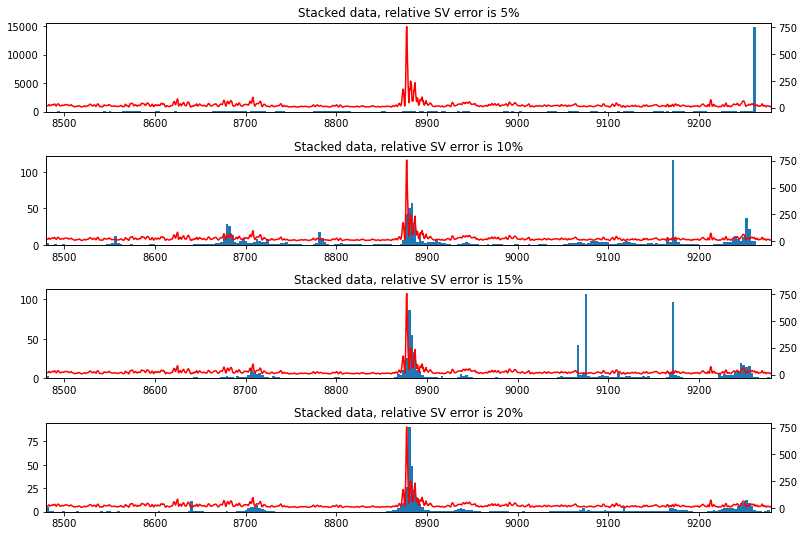

In [31]:
plt.figure()

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
fac = (NSAMPLE-burn_in)/THIN

for i in range(ax.shape[0]):
    ax[i].set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].bar(left_edges, np.sum(delta_hist_save[i,:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
    axb = ax[i].twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax[i].set_xlim(time_yearly.min(), time_yearly.max() )

    time_index_delta = np.argmax(np.sum(delta_hist_save[i,:,:],axis=0))
    print('Jerk time from stacked average of gradient is {0:f}'.
      format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)





#### Stacked data: absolute gradient of the average 

In [32]:
# Define a function to calculate the change in slope. Uses one-sided differences excluding the query point.
# This avoids the case where an apex of the function modelled, is in between two grid points x_i, and x_{i+1}. 
# Here, the left one-sided gradient at x_i, and the right one-sided gradient at x_{i+1} will be accurate, 
# but using x_i and x_{i+1} to calculate the gradient will give a large error.

def calc_delta_slope(timeseries, delta_t):
    delta_slope = np.zeros( len(timeseries) )
    
    for i in range(len(timeseries)):
        if i > 2 and i < len(timeseries)-2 :
            delta_slope[i] = abs(timeseries[i+2] -  timeseries[i+1] - timeseries[i-1] + timeseries[i-2] )/delta_t
    return delta_slope

    

Jerk time from gradient of average is 8892.121212 with SV error of 5%
Jerk time from gradient of average is 8892.121212 with SV error of 10%
Jerk time from gradient of average is 8892.121212 with SV error of 15%
Jerk time from gradient of average is 8892.121212 with SV error of 20%


<Figure size 432x288 with 0 Axes>

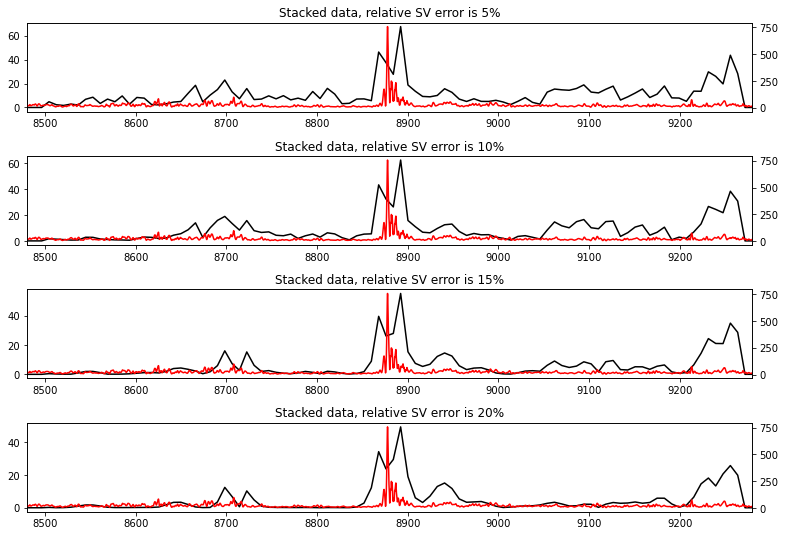

In [33]:
plt.figure()

time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)
delta_t = time_for_plotting[1] - time_for_plotting[0]

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(ax.shape[0]):
    ax[i].set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax[i].plot( time_for_plotting, 
               calc_delta_slope(av_hist_save[i,0,:],delta_t) + 
               calc_delta_slope(av_hist_save[i,1,:],delta_t) +
               calc_delta_slope(av_hist_save[i,2,:],delta_t),'k')
    axb = ax[i].twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax[i].set_xlim(time_yearly.min(), time_yearly.max() )
    
    print(r'Jerk time from gradient of average is {0:f} with SV error of {1:d}%'.format(
    time_for_plotting[(
        calc_delta_slope(av_hist_save[i,0,:],delta_t) + 
        calc_delta_slope(av_hist_save[i,1,:],delta_t) +
        calc_delta_slope(av_hist_save[i,2,:],delta_t)    ).argmax()],SV_errors[i]) )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




## Investigate the effect of the length of the given timeseries. Here, I pass the jerk finder 7000-9000, containing multiple jerks.

In [34]:
jerk_number = 8 # in Python indexing (i.e. event 9)

time_yearly = np.arange(7000,9001)


Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)



run_components=[0,1,2] #compute for X,Y,Z components of SV

SV_errors = np.array([10])
num_SV_errors = SV_errors.shape[0]

discretise_size = time_yearly.shape[0]  # one per year.

TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
delta_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=float )
CP_hist_save = np.zeros( (num_SV_errors,len(run_components),time_intervals_nbins), dtype=int )
Acceptance_rates_save = np.zeros( (num_SV_errors,len(run_components),4),dtype=float)
av_hist_save =  np.zeros( (num_SV_errors,len(run_components),discretise_size), dtype=float )

for error_j_index, error_j in enumerate(SV_errors):
    
    for run_component_index,i in enumerate(run_components):
        if i == 0:
            SV = Bx_dot
        elif i == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        delta_SV = error_j * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
        SV_MIN = -400
        SV_MAX = 400

        K_MIN = 0
        K_MAX = 100
        sigmas = np.array([20,10,20],dtype = float)
        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
        # sigma_change_value = sigmas(1)
        # sigma_move = sigmas(2)
        # sigma_birth = sigmas(3)

        THIN = 100
        NBINS = 100
        credible = 0.0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 2000000+burn_in
        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        CP_hist_save[error_j_index,run_component_index,:] = CP[:]
        delta_hist_save[error_j_index,run_component_index,:] = delta_slope[:]
        Acceptance_rates_save[error_j_index,run_component_index,:] = Acceptance_rates[:]
        av_hist_save[error_j_index,run_component_index,:] = AV[:]


#### Plot the average models:

<Figure size 432x288 with 0 Axes>

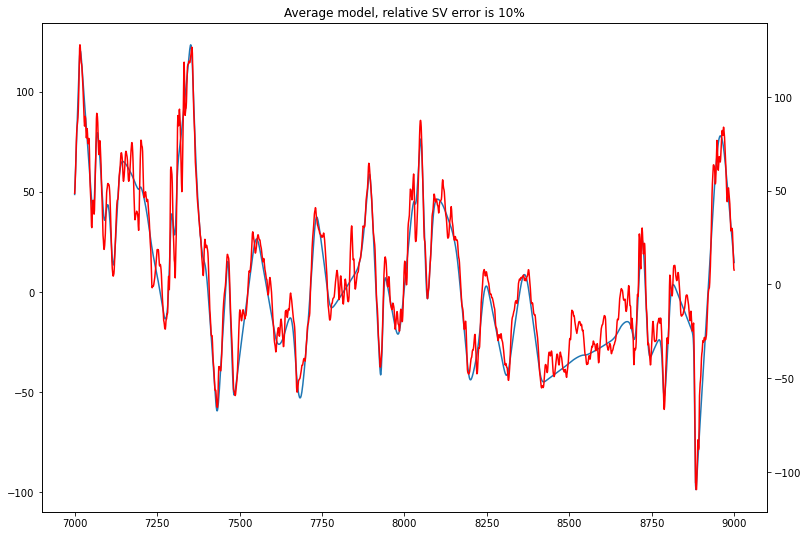

In [41]:
plt.figure()
time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)

f, ax = plt.subplots(av_hist_save.shape[0], 1, figsize=(13,9) )

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(1):
    ax.set_title(r'Average model, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax.plot(time_for_plotting, av_hist_save[i,0,:])
    axb = ax.twinx()
    axb.plot(time_yearly, Bx_dot,'r' )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




#### Stacked data: average absolute gradient

Jerk time from stacked average of gradient is 7064.500000


<Figure size 432x288 with 0 Axes>

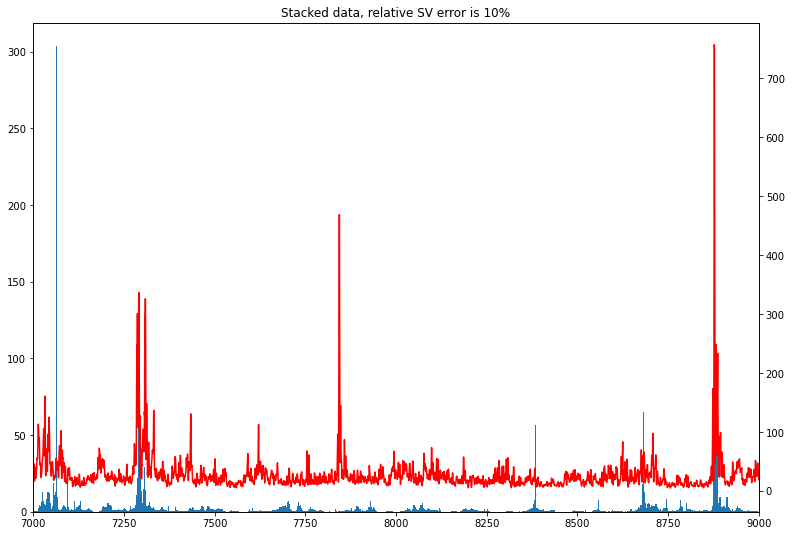

In [43]:
plt.figure()

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
fac = (NSAMPLE-burn_in)/THIN

for i in range(1):
    ax.set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax.bar(left_edges, np.sum(delta_hist_save[i,:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))
    axb = ax.twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax.set_xlim(time_yearly.min(), time_yearly.max() )

    time_index_delta = np.argmax(np.sum(delta_hist_save[i,:,:],axis=0))
    print('Jerk time from stacked average of gradient is {0:f}'.
      format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)





#### Stacked data: absolute gradient of the average 

In [44]:
# Define a function to calculate the change in slope. Uses one-sided differences excluding the query point.
# This avoids the case where an apex of the function modelled, is in between two grid points x_i, and x_{i+1}. 
# Here, the left one-sided gradient at x_i, and the right one-sided gradient at x_{i+1} will be accurate, 
# but using x_i and x_{i+1} to calculate the gradient will give a large error.

def calc_delta_slope(timeseries, delta_t):
    delta_slope = np.zeros( len(timeseries) )
    
    for i in range(len(timeseries)):
        if i > 2 and i < len(timeseries)-2 :
            delta_slope[i] = abs(timeseries[i+2] -  timeseries[i+1] - timeseries[i-1] + timeseries[i-2] )/delta_t
    return delta_slope

    

Jerk time from gradient of average is 8884.000000 with SV error of 10%


<Figure size 432x288 with 0 Axes>

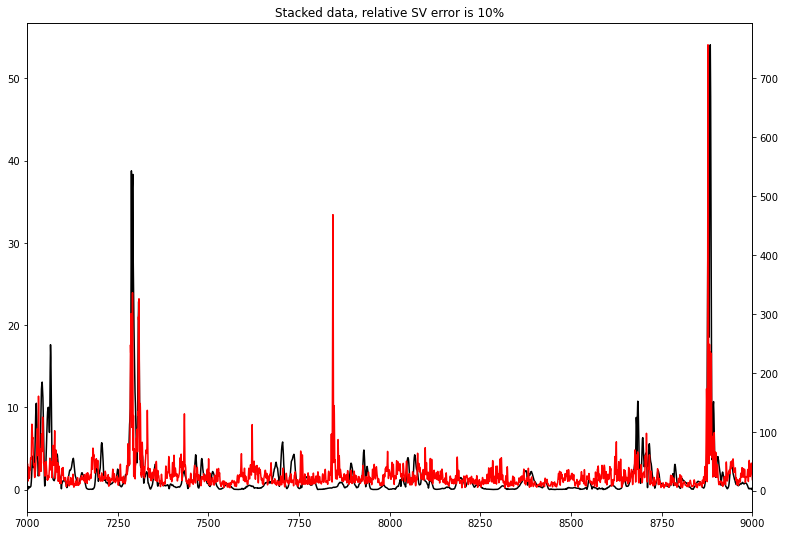

In [45]:
plt.figure()

time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)
delta_t = time_for_plotting[1] - time_for_plotting[0]

f, ax = plt.subplots(delta_hist_save.shape[0], 1, figsize=(13,9) )
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(1):
    ax.set_title(r'Stacked data, relative SV error is {0:d}%'.format(SV_errors[i]))
    ax.plot( time_for_plotting, 
               calc_delta_slope(av_hist_save[i,0,:],delta_t) + 
               calc_delta_slope(av_hist_save[i,1,:],delta_t) +
               calc_delta_slope(av_hist_save[i,2,:],delta_t),'k')
    axb = ax.twinx()
    axb.plot(time_EJ, EJ,'r' )
    ax.set_xlim(time_yearly.min(), time_yearly.max() )
    
    print(r'Jerk time from gradient of average is {0:f} with SV error of {1:d}%'.format(
    time_for_plotting[(
        calc_delta_slope(av_hist_save[i,0,:],delta_t) + 
        calc_delta_slope(av_hist_save[i,1,:],delta_t) +
        calc_delta_slope(av_hist_save[i,2,:],delta_t)    ).argmax()],SV_errors[i]) )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


